# Sketch Recognition Convolutional Neural Network (CNN)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will build a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) model using [Tensorflow](https://www.tensorflow.org/) to recognize handwritten sketches by using a [quick-draw dataset](https://github.com/googlecreativelab/quickdraw-dataset).

![sketch_recognition_cnn.png](../../demos/src/images/sketch_recognition_cnn.png)

## Import dependencies

In [2]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
cache_dir = 'tmp';

In [5]:
# Create cache folder.
!mkdir tmp

mkdir: tmp: File exists


## Load dataset

In [6]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [7]:
DATASET_NAME = 'quickdraw_bitmap'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir=cache_dir,
    with_info=True,
    split=tfds.Split.TRAIN,
)

## Explore dataset

In [8]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='quickdraw_bitmap',
    version=3.0.0,
    description='The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images',
    homepage='https://github.com/googlecreativelab/quickdraw-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=345),
    }),
    total_num_examples=50426266,
    splits={
        'train': 50426266,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/HaE17,
      author    = {David Ha and
                   Douglas Eck},
      title     = {A Neural Representation of Sketch Drawings},
      journal   = {CoRR},
      volume    = {abs/1704.03477},
      year      = {2017},
      url       = {http://arxiv.org/abs/1704.03477

In [9]:
image_shape = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

print('num_examples: ', num_examples)
print('image_shape: ', image_shape)
print('num_classes: ', num_classes)

num_examples:  50426266
image_shape:  (28, 28, 1)
num_classes:  345


In [10]:
label_index_to_string = dataset_info.features['label'].int2str

classes = []

for class_index in range(num_classes):
    classes.append(label_index_to_string(class_index))
    
print('classes:\n\n', classes)

classes:

 ['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 

In [11]:
print(dataset)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


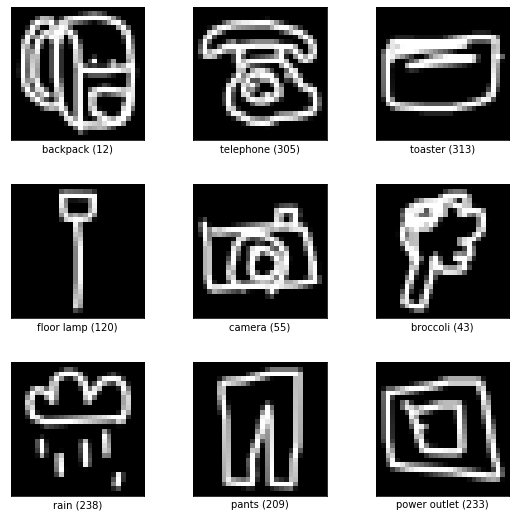

In [12]:
fig = tfds.show_examples(dataset_info, dataset)

In [13]:
def dataset_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example['image']
        label = example['label']
        
        class_index = label.numpy()
        class_name = label_index_to_string(class_index)
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [14]:
def dataset_normalized_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example[0]
        label = example[1]
        
        class_index = label.numpy()
        class_name = label_index_to_string(class_index)
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [15]:
def dataset_head(ds):
    for example in ds.take(1):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        print('{} ({})'.format(class_name, class_index), '\n')
        print('Image shape: ', image.shape, '\n')
        print(np.reshape(image.numpy(), (28, 28)), '\n')

In [16]:
dataset_head(dataset)

backpack (12) 

Image shape:  (28, 28, 1) 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3  31  63  95 115
   86  50   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  75 183 176 152  10  54 182 222 250 255 255 255 255
  255 255 231 151  61   0   0   0   0   0]
 [  0   0   0   0 129 255 216 202 255  98 220 222 157 125  93  60  28   8
   38  82 162 239 254 108   0   0   0   0]
 [  0   0   0  33 250 158   4   0 204 209 255 236 105   0   0   0   0   0
    0   0   0   6 164 254  88   0   0   0]
 [  0   0   0 158 243  30 155 235 211 255 254 185 255  97   0   0   0   0
    0   0   0   0   3 193 229  10   0   0]
 [  0   0  38 251 134 153 251 162 252 245 225   1 180 241   6   0   0   0
    0   0   0   0   0  69 255  62   0   0]
 [  0   0 150 240  26 245 145   0 116 255 149   0  75 255  58   0   0   0
    0   0   0   0   0  29 255  94   0   0]
 [  0   0 209 173  7

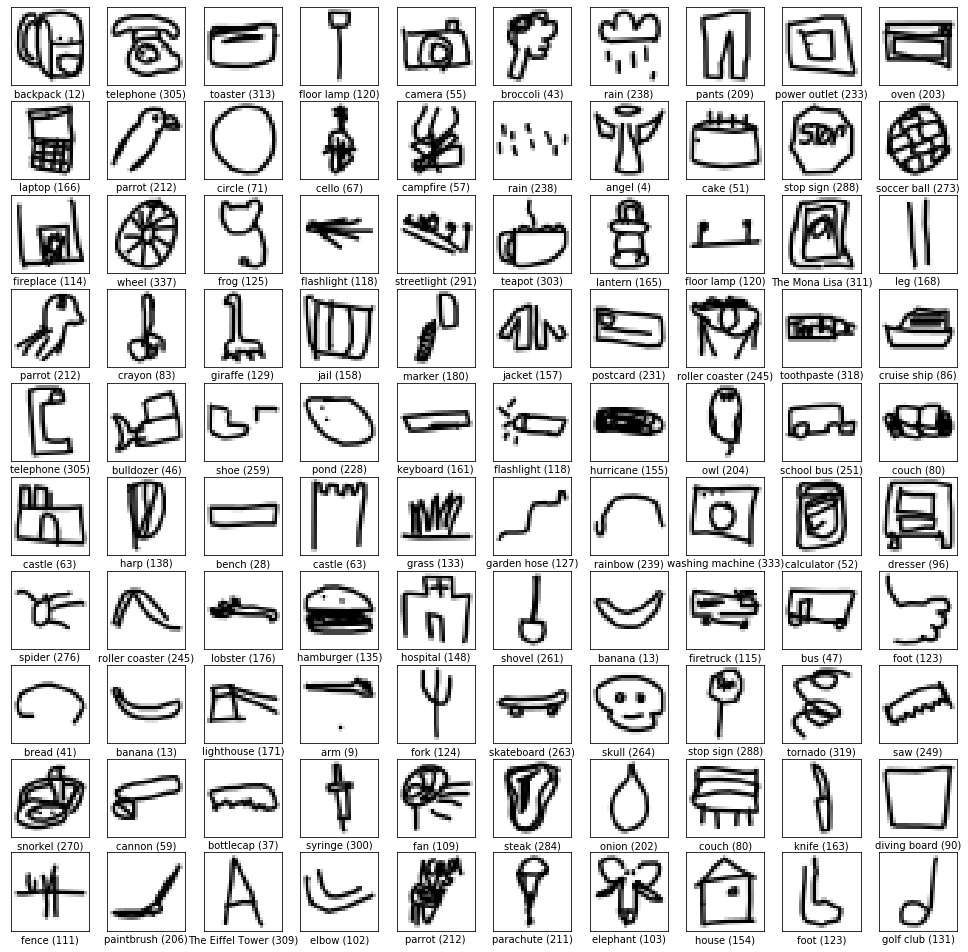

In [17]:
dataset_preview(dataset, image_shape)

## Normalize dataset

In [18]:
def normalize_example(example):
    image = example['image']
    label = example['label']
    
    image = tf.math.divide(image, 255)
    
    return (image, label)

In [19]:
def augment_example(image, label):
    image = tf.image.random_flip_left_right(image)
    return (image, label)

In [20]:
dataset_normalized = dataset.map(normalize_example).map(augment_example)

In [21]:
for (image, label) in dataset_normalized.take(1):
    class_index = label.numpy()
    class_name = label_index_to_string(class_index)

    print('{} ({})'.format(class_name, class_index), '\n')
    print('Image shape: ', image.shape, '\n')
    print(np.reshape(image.numpy(), (28, 28)), '\n')

backpack (12) 

Image shape:  (28, 28, 1) 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.01176471 0.12156863 0.24705882 0.37254903 0.4509804
  0.3372549  0.19607843 0.00784314 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.29411766
  0.7176471  0.6901961  0.59607846 0.03921569 0.21176471 0.7137255
  0.87058824 0.98039216 1.         1.         1.         1.
  1.         1.         0.90588236 0.5921569  0.23921569 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5058824  1.
  0.84705883 

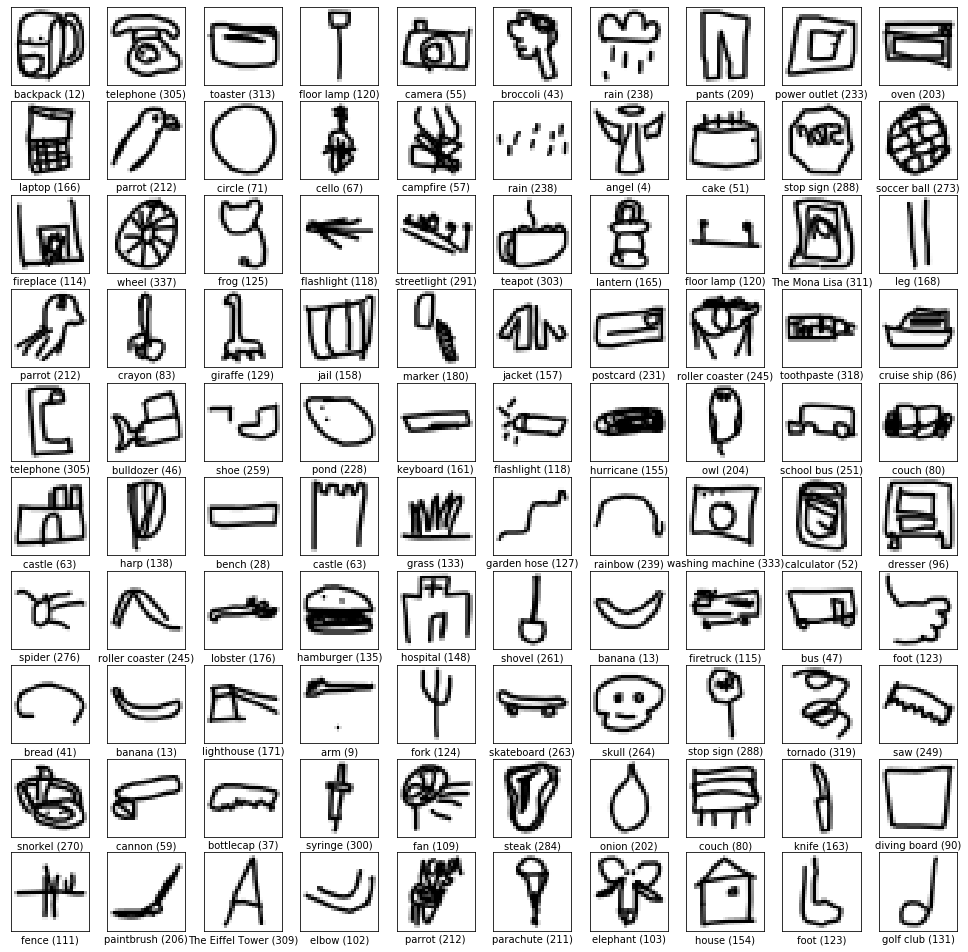

In [22]:
dataset_normalized_preview(dataset_normalized, image_shape)

## Prepare Train/Validation/Test dataset splits

In [23]:
# A quick example of how we're going to split the dataset for train/test/validation subsets.
tmp_ds = tf.data.Dataset.range(10)
print('tmp_ds:', list(tmp_ds.as_numpy_iterator()))

tmp_ds_test = tmp_ds.take(2)
print('tmp_ds_test:', list(tmp_ds_test.as_numpy_iterator()))

tmp_ds_val = tmp_ds.skip(2).take(3)
print('tmp_ds_val:', list(tmp_ds_val.as_numpy_iterator()))

tmp_ds_train = tmp_ds.skip(2 + 3)
print('tmp_ds_train:', list(tmp_ds_train.as_numpy_iterator()))

tmp_ds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp_ds_test: [0, 1]
tmp_ds_val: [2, 3, 4]
tmp_ds_train: [5, 6, 7, 8, 9]


In [134]:
# Dataset split
test_dataset_batches = 1
val_dataset_batches = 1

# Dataset batching and shuffling
shuffle_buffer_size = 10000
batch_size = 10000
prefetch_buffer_batches = 10

# Training
epochs = 40
steps_per_epoch = 100

In [135]:
dataset_batched = dataset_normalized \
    .shuffle(
        buffer_size=shuffle_buffer_size,
        reshuffle_each_iteration=True
    ) \
    .batch(batch_size=batch_size)

In [136]:
# TEST dataset.
dataset_test = dataset_batched \
    .take(test_dataset_batches)

# VALIDATION dataset.
dataset_val = dataset_batched \
    .skip(test_dataset_batches) \
    .take(val_dataset_batches)

# TRAIN dataset.
dataset_train = dataset_batched \
    .skip(test_dataset_batches + val_dataset_batches) \
    .prefetch(buffer_size=prefetch_buffer_batches) \
    .repeat()

In [137]:
for (image_test, label_test) in dataset_test.take(1):
    print('label_test.shape: ', label_test.shape)
    print('image_test.shape: ', image_test.shape)
    
print()    
    
for (image_val, label_val) in dataset_val.take(1):
    print('label_val.shape: ', label_val.shape)
    print('image_val.shape: ', image_val.shape)    
    
print()    
    
for (image_train, label_train) in dataset_train.take(1):
    print('label_train.shape: ', label_train.shape)
    print('image_train.shape: ', image_train.shape)    

label_test.shape:  (10000,)
image_test.shape:  (10000, 28, 28, 1)

label_val.shape:  (10000,)
image_val.shape:  (10000, 28, 28, 1)

label_train.shape:  (10000,)
image_train.shape:  (10000, 28, 28, 1)


## Create model

In [138]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=image_shape,
    kernel_size=3,
    filters=32,
    padding='same',
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=3,
    filters=32,
    padding='same',
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=3,
    filters=64,
    padding='same',
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=2,
    strides=2
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

In [139]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)              

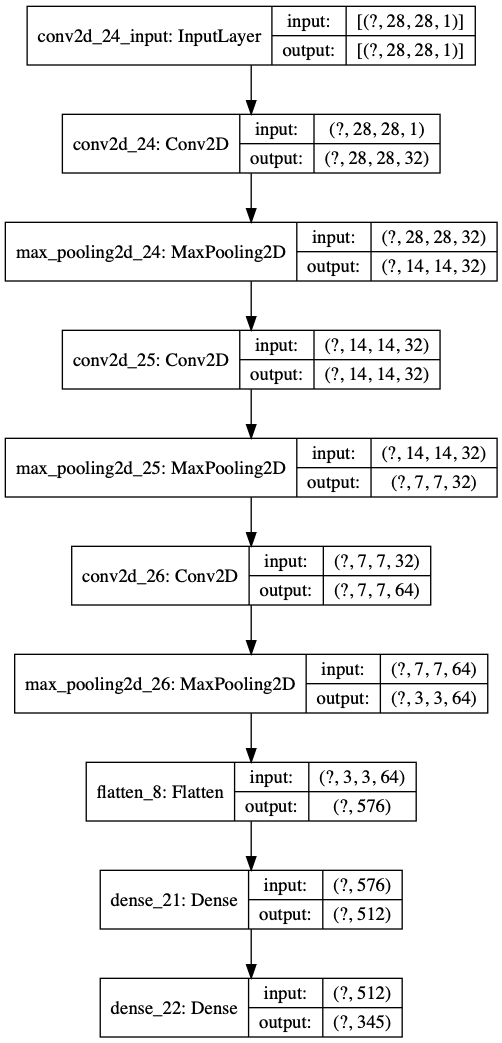

In [140]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [141]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rms_prop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Train model

In [142]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)

In [144]:
training_history = model.fit(
    x=dataset_train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    callbacks=[
        early_stopping_callback
    ]
)

Train for 100 steps
Epoch 1/40
  1/100 [..............................] - ETA: 41:01WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: 


  1/100 [..............................] - ETA: 41:07

KeyboardInterrupt: 

In [ ]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

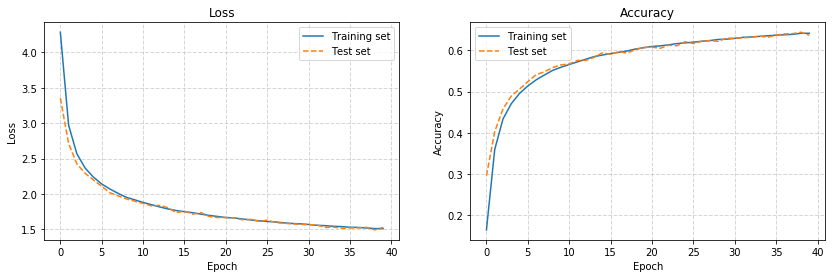

In [145]:
render_training_history(training_history)

## Evaluate model accuracy

### Training set accuracy

In [146]:
%%capture
train_loss, train_accuracy = model.evaluate(dataset_train.take(1))

In [147]:
print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  1.48
Train accuracy:  0.64


### Validation set accuracy

In [148]:
%%capture
val_loss, val_accuracy = model.evaluate(dataset_val)

In [149]:
print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  1.51
Validation accuracy:  0.64


### Test set accuracy

In [150]:
%%capture
test_loss, test_accuracy = model.evaluate(dataset_test)

In [151]:
print('Test loss: ', '{:.2f}'.format(test_loss))
print('Test accuracy: ', '{:.2f}'.format(test_accuracy))

Test loss:  1.50
Test accuracy:  0.64


### Visualizing Predictions

In [152]:
def visualize_predictions(model, dataset):
    numbers_to_display = 64
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(15, 15))
    
    batch = dataset.take(1)
    predictions = tf.math.argmax(model.predict(batch), axis=1).numpy()

    for x, y in batch:
        for image_index in range(numbers_to_display):
            pixels = np.reshape(x[image_index].numpy(), (28, 28))
            y_correct = y[image_index].numpy()
            y_predicted = predictions[image_index]
            correct_label = classes[y_correct]
            predicted_label = classes[y_predicted]
            
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            color_map = 'Greens' if y_correct == y_predicted else 'Reds'
            plt.subplot(num_cells, num_cells, image_index + 1)
            plt.imshow(pixels, cmap=color_map)
            plt.xlabel(predicted_label + ' [' + correct_label + ']')
            
    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()

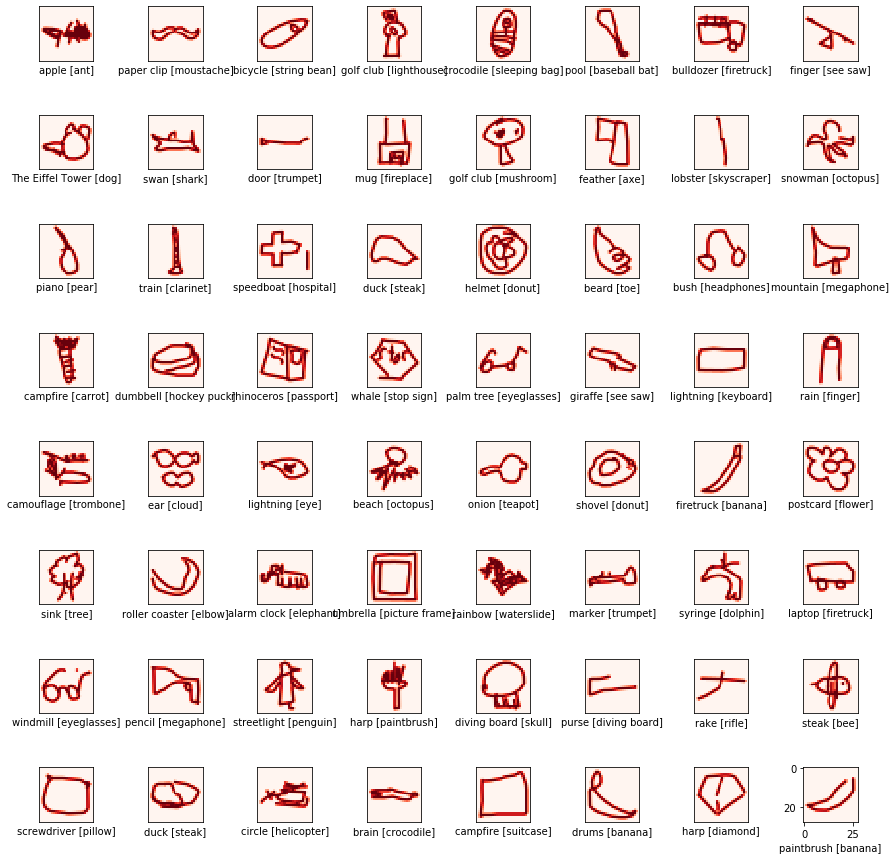

In [153]:
visualize_predictions(model, dataset_train)

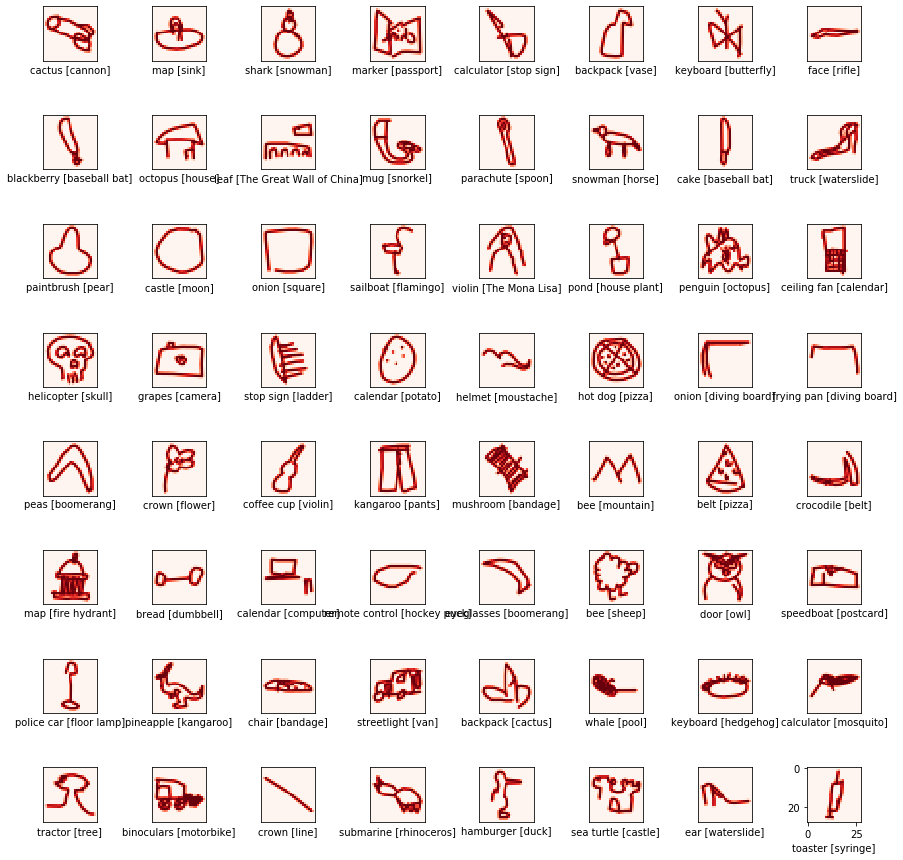

In [154]:
visualize_predictions(model, dataset_test)

## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model should be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [155]:
model_name = 'sketch_recognition_cnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/sketch_recognition_cnn/sketch_recognition_cnn.h5 \
  ./demos/public/models/sketch_recognition_cnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.

## Fine-tuning and experimentations with models

The sections below are pretty noisy, it has a lot of logs and debugging data. The reason for debugging is trying to figure out why we've got to that 60% accuracy plateau and how we could break through the plateau and increase the accuracy.

In [773]:
def get_datasets(
    test_dataset_batches,
    val_dataset_batches,
    shuffle_buffer_size,
    batch_size,
    prefetch_buffer_batches
):
    # Split on batches.
    ds_batched = dataset_normalized \
        .shuffle(
            buffer_size=shuffle_buffer_size,
            reshuffle_each_iteration=True
        ) \
        .batch(batch_size=batch_size)
    
    # TEST dataset.
    ds_test = ds_batched \
        .take(test_dataset_batches)

    # VALIDATION dataset.
    ds_val = ds_batched \
        .skip(test_dataset_batches) \
        .take(val_dataset_batches)

    # TRAIN dataset.
    ds_train = ds_batched \
        .skip(test_dataset_batches + val_dataset_batches) \
        .prefetch(buffer_size=prefetch_buffer_batches) \
        .repeat()
    
    return ds_train, ds_val, ds_test

In [820]:
def build_models():
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.sparse_categorical_crossentropy
    relu = tf.keras.activations.relu
    
    # Model 1
    model_0 = tf.keras.models.Sequential()
    model_0.add(tf.keras.layers.Flatten(input_shape=image_shape))
    model_0.add(tf.keras.layers.Dense(units=784, activation=relu))
    model_0.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
    model_0.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
#     # Model 1
#     model_1 = tf.keras.models.Sequential()
#     model_1.add(tf.keras.layers.Flatten(input_shape=image_shape))
#     model_1.add(tf.keras.layers.Dense(units=256, activation=relu))
#     model_1.add(tf.keras.layers.Dense(units=256, activation=relu))
#     model_1.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
#     model_1.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
#     # Model 2
#     model_2 = tf.keras.models.Sequential()
#     model_2.add(tf.keras.layers.Flatten(input_shape=image_shape))
#     model_2.add(tf.keras.layers.Dense(units=512, activation=relu))
#     model_2.add(tf.keras.layers.Dense(units=512, activation=relu))
#     model_2.add(tf.keras.layers.Dense(units=512, activation=relu))
#     model_2.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
#     model_2.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
    # Model 3
    model_3 = tf.keras.models.Sequential()
    model_3.add(tf.keras.layers.Flatten(input_shape=image_shape))
    model_3.add(tf.keras.layers.Dense(units=784, activation=relu))
    model_3.add(tf.keras.layers.Dense(units=512, activation=relu))
#     model_3.add(tf.keras.layers.Dense(units=128, activation=relu))
#     model_3.add(tf.keras.layers.Dense(units=128, activation=relu))
#     model_3.add(tf.keras.layers.Dense(units=128, activation=relu))
    model_3.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
    model_3.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
    # Model 4
    model_4 = tf.keras.models.Sequential()
    model_4.add(tf.keras.layers.Convolution2D(input_shape=image_shape, kernel_size=5, filters=16, activation=relu))
    model_4.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    model_4.add(tf.keras.layers.Convolution2D(kernel_size=5, filters=32, activation=relu))
    model_4.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    model_4.add(tf.keras.layers.Flatten())
    model_4.add(tf.keras.layers.Dense(units=256, activation=relu))
    model_4.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
    model_4.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
    # Model 5
    model_5 = tf.keras.models.Sequential()
    model_5.add(tf.keras.layers.Convolution2D(input_shape=image_shape, kernel_size=5, filters=8, activation=relu))
    model_5.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    model_5.add(tf.keras.layers.Convolution2D(kernel_size=5, filters=16, activation=relu))
    model_5.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    model_5.add(tf.keras.layers.Convolution2D(kernel_size=3, filters=32, activation=relu))
    model_5.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    model_5.add(tf.keras.layers.Flatten())
    model_5.add(tf.keras.layers.Dense(units=512, activation=relu))
    model_5.add(tf.keras.layers.Dense(units=256, activation=relu))
    model_5.add(tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax))
    model_5.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
    
    return [
        model_0,
#         model_1,
#         model_2,
        model_3,
        model_4,
        model_5
    ]

In [823]:
def train_model(
    model_name,
    model,
    epochs=10,
    steps_per_epoch=10,
    test_dataset_batches=1,
    val_dataset_batches=1,
    shuffle_buffer_size=1000,
    batch_size=1000,
    prefetch_buffer_batches=10
):
    print('Model SUMMARY')
    print('-------------')
    print(model_name)
    print()
    
    print('Model SUMMARY')
    print('-------------')
    
    model.summary()
    
    print('\n\n')
    print('Model TRAINING')
    print('-------------')
    
    ds_train, ds_val, ds_test = get_datasets(
        test_dataset_batches=test_dataset_batches,
        val_dataset_batches=val_dataset_batches,
        shuffle_buffer_size=shuffle_buffer_size,
        batch_size=batch_size,
        prefetch_buffer_batches=prefetch_buffer_batches
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_accuracy',
        restore_best_weights=True,
        verbose=1
    )
    
    training_history = model.fit(
        x=ds_train,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_val,
        callbacks=[early_stopping]
    )
    
    print('\n\n')
    print('Model EVALUATION')
    print('-------------')
    
    train_loss, train_accuracy = model.evaluate(dataset_train.take(1))
    val_loss, val_accuracy = model.evaluate(dataset_val)
    test_loss, test_accuracy = model.evaluate(dataset_test)
    
    print('\n\n')
    print('Training HISTORY')
    print('-------------')
    
    render_training_history(training_history)
    
    print('\n\n')
    print('Model PERFORMANCE')
    print('-------------')
    
    print('Train loss: ', '{:.2f}'.format(train_loss))
    print('Train accuracy: ', '{:.2f}'.format(train_accuracy))
    print()
    print('Validation loss: ', '{:.2f}'.format(val_loss))
    print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))
    print()
    print('Test loss: ', '{:.2f}'.format(test_loss))
    print('Test accuracy: ', '{:.2f}'.format(test_accuracy))
    
    print('\n\n')
    print('Model SAVE')
    print('-------------')
    
    model.save(model_name, save_format='h5')
    
    print('\n\n========================================================')
    print('========================================================\n\n\n')
    
    return model, training_history

Model SUMMARY
-------------
model_0.h5

Model SUMMARY
-------------
Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_168 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_649 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_650 (Dense)            (None, 345)               270825    
Total params: 886,265
Trainable params: 886,265
Non-trainable params: 0
_________________________________________________________________



Model TRAINING
-------------
Train for 100 steps
Epoch 1/30
100/100 [==============================] - 19s 189ms/step - loss: 4.7190 - accuracy: 0.1152 - val_loss: 4.0712 - val_accuracy: 0.2000
Epoch 2/30
100/100 [==============================] - 17s 173ms/step - loss: 3.9475 - accuracy: 0.2121 - val_lo

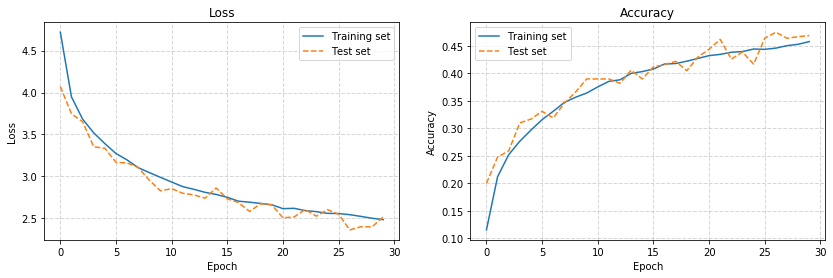




Model PERFORMANCE
-------------
Train loss:  2.49
Train accuracy:  0.46

Validation loss:  2.49
Validation accuracy:  0.46

Test loss:  2.49
Test accuracy:  0.46



Model SAVE
-------------





Model SUMMARY
-------------
model_1.h5

Model SUMMARY
-------------
Model: "sequential_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_169 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_651 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_652 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_653 (Dense)            (None, 345)               176985    
Total params: 1,194,345
Trainable params: 1,194,345
Non-trainable params: 0
________________________________________

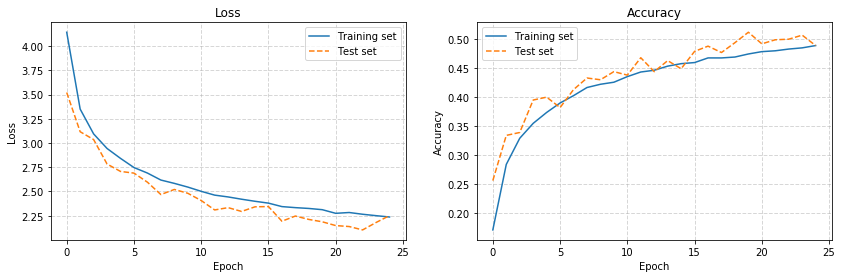




Model PERFORMANCE
-------------
Train loss:  2.28
Train accuracy:  0.48

Validation loss:  2.27
Validation accuracy:  0.48

Test loss:  2.27
Test accuracy:  0.48



Model SAVE
-------------





Model SUMMARY
-------------
model_2.h5

Model SUMMARY
-------------
Model: "sequential_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_170 (Flatten)        (None, 512)          

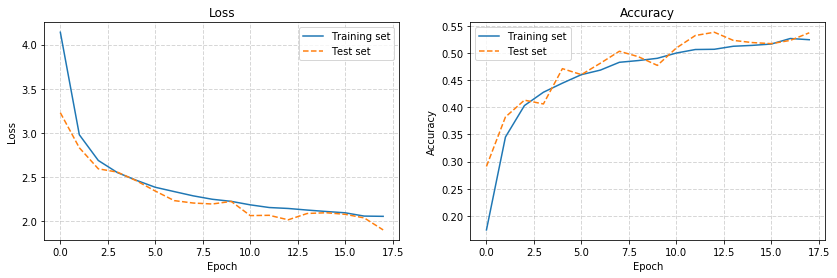




Model PERFORMANCE
-------------
Train loss:  2.12
Train accuracy:  0.52

Validation loss:  2.11
Validation accuracy:  0.52

Test loss:  2.12
Test accuracy:  0.51



Model SAVE
-------------





Model SUMMARY
-------------
model_3.h5

Model SUMMARY
-------------
Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 8, 8, 16)          3216      
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 2, 2, 32)     

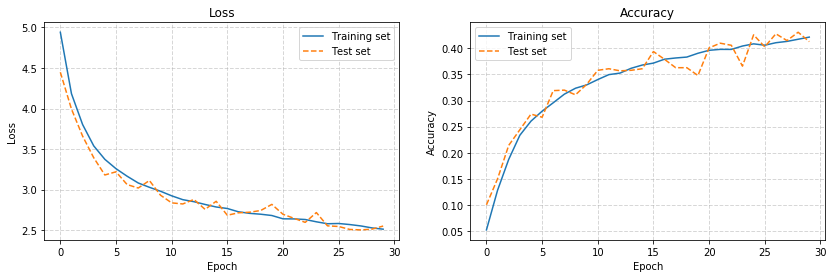




Model PERFORMANCE
-------------
Train loss:  2.54
Train accuracy:  0.42

Validation loss:  2.53
Validation accuracy:  0.42

Test loss:  2.50
Test accuracy:  0.42



Model SAVE
-------------







In [825]:
tmp_models = build_models()

for tmp_model_index, tmp_model in enumerate(tmp_models):
    train_model(
        model_name='model_' + str(tmp_model_index) + '.h5',
        model=tmp_model,
        epochs=30,
        steps_per_epoch=100,
        shuffle_buffer_size=1000,
        batch_size=1000,
    )

Model SUMMARY
-------------
model_2_0.h5

Model SUMMARY
-------------
Model: "sequential_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_172 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_659 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_660 (Dense)            (None, 345)               270825    
Total params: 886,265
Trainable params: 886,265
Non-trainable params: 0
_________________________________________________________________



Model TRAINING
-------------
Train for 1000 steps
Epoch 1/30
1000/1000 [==============================] - 181s 181ms/step - loss: 3.4985 - accuracy: 0.2849 - val_loss: 2.9321 - val_accuracy: 0.3640
Epoch 2/30
1000/1000 [==============================] - 181s 181ms/step - loss: 2.7836 - accuracy: 0.4024

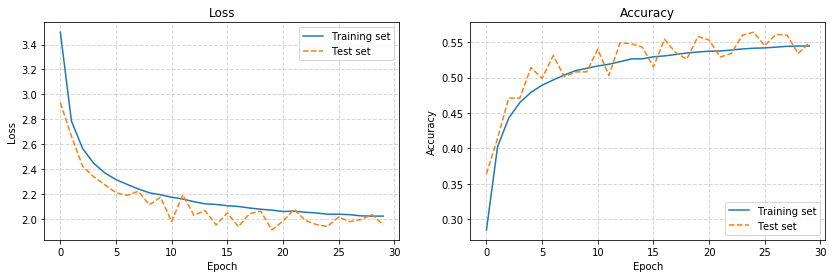




Model PERFORMANCE
-------------
Train loss:  2.03
Train accuracy:  0.54

Validation loss:  2.04
Validation accuracy:  0.54

Test loss:  2.01
Test accuracy:  0.55



Model SAVE
-------------





Model SUMMARY
-------------
model_2_1.h5

Model SUMMARY
-------------
Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_173 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_661 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_662 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_663 (Dense)            (None, 345)               176985    
Total params: 1,194,345
Trainable params: 1,194,345
Non-trainable params: 0
______________________________________

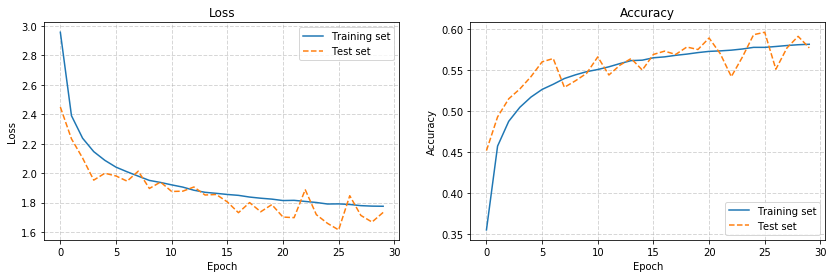




Model PERFORMANCE
-------------
Train loss:  1.75
Train accuracy:  0.59

Validation loss:  1.75
Validation accuracy:  0.59

Test loss:  1.76
Test accuracy:  0.58



Model SAVE
-------------





Model SUMMARY
-------------
model_2_2.h5

Model SUMMARY
-------------
Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_174 (Flatten)        (None, 512)        

KeyboardInterrupt: 

In [826]:
tmp_models = build_models()

for tmp_model_index, tmp_model in enumerate(tmp_models):
    train_model(
        model_name='model_2_' + str(tmp_model_index) + '.h5',
        model=tmp_model,
        epochs=30,
        steps_per_epoch=1000,
        shuffle_buffer_size=1000,
        batch_size=1000,
    )